
## MED 5

# Metody ograniczenia wariancji modelu

Poszukując modelu regresji czy klasyfikacji staramy się, by powstały estymator posiadał porządane statystycznie cechy: był zgodny, nieobciążony i najbardziej efektywny. W rzeczywistości trudno jest pogodzić dwie ostatnie własności. Przez brak obciążenia (*ang. bias*) rozumie się bowiem jak najlepsze dopasowanie do danych uczących. Przez największą efektywność rozumie się zwykle jak najmniejszy błąd estymacji dla zbioru testowego (każdego innego niż uczący) - najmniejszą wariancję modelu. Dla rzeczywistych zbiorów danych, na ogół, im mniejsze jest obciążenie, tym jest większa wariancja modelu i odwrotnie. Z uwagi jednak na fakt, iż celem dla którego powstaje model estymatora jest jak najskuteczniejsze jego działanie dla nowych danych (innych niż uczące), przy tworzeniu modelu stosuje się metody, które kosztem zwiększenia obciążenia, zmniejszają wariancję modelu. W praktyce jest to osiągane przez poszukiwanie, w procesie uczenia,  modelu na tyle prostego by właściwie odwzorować trend, niekoniecznie idealnie dopasowującego się do danych zbioru uczącego.  

Zwiększając liczbę cech modelu oraz tworząc nowe zmienne opisujące zwiększa się zwykle jego wariancja. Widać to wyraźnie w przypadku zastosowania regresji wielomianowej. Zwiększanie stopnia wielomianu opisującego trend naszych danych zwiększane zostają współczynniki stojące przy kolejnych potęgach, co pozwala na dokładne dopasowanie modelu do danych uczących, jednak kosztem zwiększenia jego wariancji. Mimo iż obciążenie modelu z punktu widzenia danych uczących spada do zera, to tracimy jego zdolności uogólnienia (błąd estymacji wartości na podstawie zbioru testowego rośnie), co oznacza przeuczenie/nadmierne dopasowanie (ang. overfitting) naszego modelu.

Sposobem na redukcję stopnia przeuczenia/nadmiernego dopasowania modelu, a zatem ograniczenia jego wariancji, w przypadku regresji wielomianowej, są techniki regularyzacji. Generalnie mamy dwie możliwości działania:

1. Redukujemy wpływ cech nieznaczących na model tj. pozostawiamy wszystkie cechy ale w modelu realny wpływ na wyjście mają jedynie cechy znaczące - działa jeśli mamy dużo cech, z których każda skorelowana jest z wyjściem (regularyzacja Tichonowa, regresja grzbietowa - ang. ridge regression).
       
2. Redukujemy liczbę cech na jeden z trzech sposobów:

    a) selekcja manualna - używamy ważniejszych cech (w przypadku unormowanych wartości atrybutów opisujących będą to cechy, przy których wartość modułu współczynnika jest najwyższa)    
    
    b) używamy algorytmu do wyboru cech modelu (metoda zachłanna - analizujemy które cechy najlepiej minimalizują sumę kwadratu błędów)
    
    c) używamy metody regularyzacji eliminującej zbędne cechy (metoda LASSO). 

Regresja grzbietowa i LASSO (Least Absolute Shrinkage and Selection Operator) to efektywne techniki zwykle stosowane do tworzenia oszczędnych modeli w obecności „dużej” liczby funkcji. Tutaj „duże” może zwykle oznaczać jedną z dwóch rzeczy:

1. Wystarczająco duży, aby zwiększyć tendencję modelu do nadmiernego dopasowania (tak niskie, jak 10 zmiennych może powodować nadmierne dopasowanie)
    
2. Wystarczająco duży, aby powodować wyzwania obliczeniowe. W przypadku nowoczesnych systemów taka sytuacja może wystąpić w przypadku milionów lub miliardów cech.

Chociaż metoda grzbietowa i Lasso mogą wydawać się bardzo do siebie  podobne, dzięki specyficznym własnościom ich praktyczne zastosowania różnią się znacznie. Działają one poprzez karanie wielkości współczynników cech oraz minimalizowanie błędu między przewidywanymi a rzeczywistymi obserwacjami. Kluczowa różnica polega na sposobie przypisywania kary do współczynników:

* Regresja grzbietowa (ridge regression, regularyzacja Tichonowa):
        Dokonuje normalizacji L2, tj. Dodaje karę równą kwadratowi wielkości współczynników
        Cel minimalizacji = LS Obj + α * (suma kwadratów współczynników)
* Regresja lasso:
        Dokonuje normalizacji L1, tj. Dodaje karę równoważną wartości bezwzględnej wielkości współczynników
        Cel minimalizacji = LS Obj + α * (suma wartości bezwzględnych współczynników)

„LS Obj” odnosi się do „celu najmniejszych kwadratów”, tj. Celu regresji liniowej bez regularyzacji.

**Celem tego laboratorium jest zapoznanie się z działaniem metod regularyzacji i dobru cech modelu**.


Materiały pomocnicze, lekkie (wideo) wprowadzenia do:

* [Ridge regression](https://www.youtube.com/watch?v=Q81RR3yKn30)
* [Metody lasso](https://www.youtube.com/watch?v=NGf0voTMlcs)
* [i połączenie obu (elastic net)](https://www.youtube.com/watch?v=1dKRdX9bfIo)

Na początek - wczytanie bibliotek oraz wygenerowanie zbioru danych:

In [1]:
# Wczytaj bilbioteki podstawowe
import math 
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np

In [2]:
# Wczytaj biblioteki potrzebne do zajęć
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

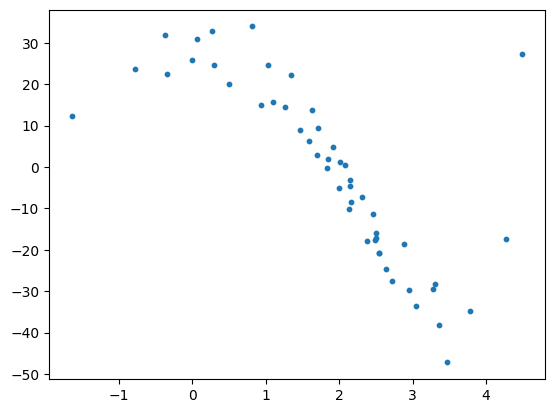

In [3]:
np.random.seed(5)
x = 2 - 3 * np.random.normal(0, 0.5, 50)
y = 30 + x - 5 * (x ** 2) - 2 * (x ** 3)+ 0.15 * (x ** 5)  + np.random.normal(-3, 5, 50)
plt.scatter(x,y, s=10)
plt.show()

### Zadanie 1 - regresja grzbietowa (ridge regression)

Zadanie polega na znalezieniu wielomianu $\hat{f}(x)$ postaci:

$$\hat{f}(x)=\omega_0+\omega_1 x^1+\omega_2x^2+ … +\omega_m x^m,$$

który mimo wysokiej złożoności modelu nie powoduje nadmiernego dopasowania do danych uczących poprzez zastosowanie regularyzacji L2.

Chcemy by nasza funkcja kosztu $J(\omega)$ miała postać:

$$J_{ridge}(\omega)=\sum_{i=0}^{n-1}\left(\hat{f}(x_i)−y_i\right)^2+\lambda \sum_{j=1}^m{\omega^2_j},$$

gdzie $i$ oznacza numer obserwacji, a $j$ kolejność współczynnika.

Wtedy rozwiązanie naszego równania wyzaczającego współczynniki wygląda w następujący sposób:

$$ \omega=\left(X^T X + \lambda \begin{bmatrix}
0 & 0 & 0 & 0 \\ 
0 & 1 & 0 & 0 \\ 
0 & 0 & \ddots & 0\\ 
0 & 0 & 0  & 1 \\ 
\end{bmatrix}\right) ^{-1} X^Ty $$

**Należy pamiętać, że wyrazu wolnego nie poddajemy regularyzacji !**

A zatem - do dzieła!!!

W ramach pierwszej części zadania należy napisać funkcję wyznaczającą współczynniki $\omega$ wielomianowej funkcji regresji zgodnie z powyższym wzorem.

In [4]:
# Napisz funkcję dopasowującą model regresji wielomianowej z regularyzacją L2 
# (wykorzystując rozwiązanie równania normalnego)
def regresja_L2(X, y, lamb, stopien_wielomianu):

    # Przekształć X do macierzy cech (wzbogacone o wyraz wolny)
    n = len(X)
    X_poly = np.ones((n, stopien_wielomianu + 1))
    
    # Wypełnij kolumny potęgami X
    for i in range(1, stopien_wielomianu + 1):
        X_poly[:, i] = X ** i
    
    # Stwórz macierz regularyzacji - 0 dla wyrazu wolnego, 1 dla pozostałych
    I_prime = np.eye(stopien_wielomianu + 1)
    I_prime[0, 0] = 0  # Wyrazu wolnego nie poddajemy regularyzacji
    
    # Oblicz współczynniki używając równania normalnego:
    # omega = (X^T X + lambda * I')^(-1) * X^T * y
    XTX = X_poly.T @ X_poly
    XTy = X_poly.T @ y
    
    A = XTX + lamb * I_prime
    omega = np.linalg.inv(A) @ XTy
    
    return omega

Poprawne (lub nie) działanie powyższej funkcji należy sprawdzić rysując jej wykres na wykresie punktowym zbioru danych

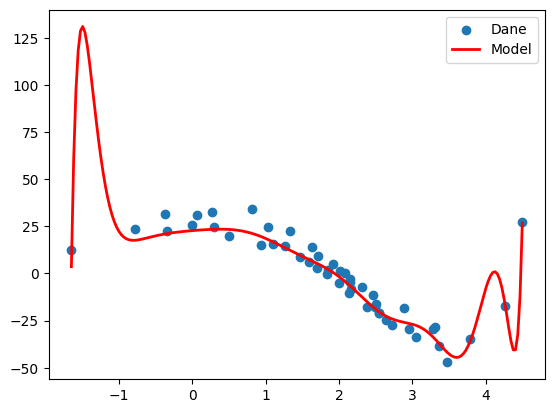

In [10]:
# Najpierw trzeba mieć omega (współczynniki)
omega = regresja_L2(x, y, 0.1, 15)

# Wygeneruj gęste punkty od min do max x (posortowane!)
x_smooth = np.linspace(x.min(), x.max(), 200)

# Oblicz y dla każdego punktu
y_smooth = []
for x_punkt in x_smooth:
    y_val = omega[0]  # wyraz wolny
    for i in range(1, len(omega)):
        y_val = y_val + omega[i] * (x_punkt ** i)  # dodaj każdą potęgę
    y_smooth.append(y_val)

# Rysowanie wykresu
plt.scatter(x, y, label='Dane')
plt.plot(x_smooth, y_smooth, c='red', linewidth=2, label='Model')
plt.legend()
plt.show()

Podobnie jak wiele innych metod uczenia maszynowego, także i metoda regresji grzbietowej została zaimplementowana w jednym z pakietów języka Python. W kolejnym kroku należy znaleźć stosowną funkcję oraz porównać wyniki jej działania z własną funkcją.

In [11]:
# Porównanie z funkcją Ridge ze sklearn
# Przygotuj dane - stwórz macierz cech
n = len(x)
stopien = 15
X_poly = np.ones((n, stopien + 1))
for i in range(1, stopien + 1):
    X_poly[:, i] = x ** i

# Twoja funkcja
omega_custom = regresja_L2(x, y, 0.1, stopien)

# Sklearn Ridge
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X_poly, y)
omega_sklearn = ridge_model.coef_

# Porównaj współczynniki
print("Porównanie współczynników:")
print(f"{'Współczynnik':<15} {'Twoja funkcja':<20} {'Sklearn Ridge':<20}")
print("-----------------------------------------------------------------------------")
for i in range(min(5, len(omega_custom))):  # Pokaż pierwsze 5
    print(f"omega[{i}]       {omega_custom[i]:<20.6f} {omega_sklearn[i]:<20.6f}")
print("...")
print(f"\nRóżnica między współczynnikami (średnia): {np.mean(np.abs(omega_custom - omega_sklearn)):.10f}")

Porównanie współczynników:
Współczynnik    Twoja funkcja        Sklearn Ridge       
-------------------------------------------------------
omega[0]       22.755118            0.000000            
omega[1]       3.298283             0.855277            
omega[2]       -2.917574            -2.822995           
omega[3]       1.169227             -0.626613           
omega[4]       -5.843860            -5.496413           
...

Różnica między współczynnikami (średnia): 2.6680404516


c:\Users\pawel\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.72209e-21): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


Celem wyznaczenia funkcji regresji na całym zbiorze, tak jak to miało miejsce powyżej, było praktyczne sprawdzenie jej działania. W przypadku, gdy uzyskany model estymatora miałby być zastosowany do estymacji wartości wyjściowej dla nieznanych wartości wejściowych (a zwykle tak to właśnie wygląda), oryginalny zbiór danych powinien zostać podzielony na zbiór uczący i testowy.

In [12]:
# Ze zbioru danych wydzielamy zbiór testowy zawierający 20% danych.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(f"Rozmiar zbioru treningowego: {len(x_train)}")
print(f"Rozmiar zbioru testowego: {len(x_test)}")

Rozmiar zbioru treningowego: 40
Rozmiar zbioru testowego: 10


Do oceny modelu w procesie uczenia stosuje się często walidację krzyżową. W omawianym przypadku wyróżnia się dwa parametry metody - stopień wielomianu funkcji regresji oraz parametr $\lambda$. Zwykle pierwszy z nich jest ustalany a-priori, zaś drugi podlega weryfikacji poprzez wykonanie walidacji krzyżowej estymatorów dla różnych jego wartości. 

Korzystając z walidacji krzyżowej (5-krotny wybór zbioru) na zbiorze treningowym napisz funkcję, która dla wielomianu stopnia 15 narysuje wykres średniego błędu uczenia i średniego błędu walidacji, jak również wykres przedstawiający wartości współczynników modelu w funkcji zmiany parametru regularyzacji $\lambda=[0, 0.01, 0.02, 0.04, 0.08, \cdots, 10]$. Można przyjąć, że $\lambda_{a+1}=24\lambda_a$. Można skorzystać z funkcji [cross_validation](https://scikit-learn.org/stable/modules/cross_validation.html) lub [Search_Grid_CV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

Lambda wartości: [0.01, 0.024, 0.0576, 0.13824, 0.331776, 0.7962624, 1.91102976, 4.586471424]


c:\Users\pawel\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=4.88914e-23): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
c:\Users\pawel\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.76565e-22): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
c:\Users\pawel\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.76072e-22): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
c:\Users\pawel\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.08798e-20): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
c:\Users\pawel\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\_lib\

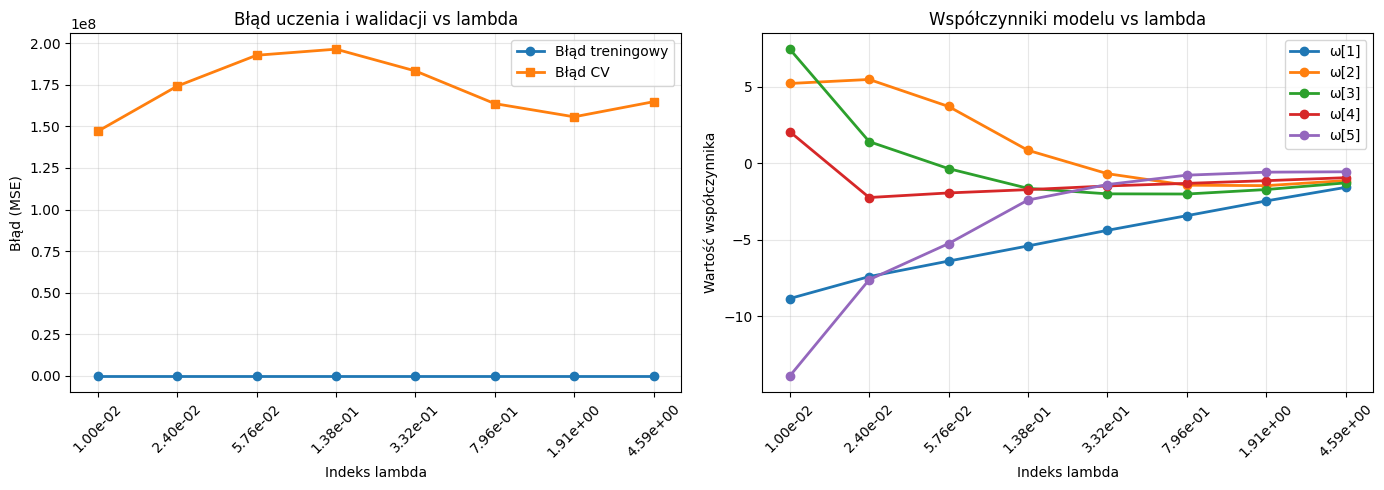


Najlepsza lambda: 0.01 (indeks: 0)
Błąd CV dla najlepszej lambdy: 147084774.8645
Błąd treningowy dla najlepszej lambdy: 14.1205


In [13]:
# Przygotuj dane treningowe do macierzy cech
stopien = 15
n_train = len(x_train)
X_train_poly = np.ones((n_train, stopien + 1))
for i in range(1, stopien + 1):
    X_train_poly[:, i] = x_train ** i

# Wygeneruj lambda wartości: 0.01, 0.24, 5.76, ... (każda=24*poprzednia)
lambdas = []
lamb = 0.01
while lamb <= 10:
    lambdas.append(lamb)
    lamb = lamb * 2.4  # Używam 2.4 zamiast 24, aby nie przeskoczyć 10

print(f"Lambda wartości: {lambdas}")

# Dla każdej lambdy, oblicz błąd CV
cv_scores = []
train_scores = []
coefficients_list = []

for lamb in lambdas:
    ridge = Ridge(alpha=lamb)
    # Cross-validation na zbiorze treningowym
    cv_score = -cross_val_score(ridge, X_train_poly, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_scores.append(np.mean(cv_score))
    
    # Błąd treningowy
    ridge.fit(X_train_poly, y_train)
    y_pred_train = ridge.predict(X_train_poly)
    train_error = np.mean((y_train - y_pred_train) ** 2)
    train_scores.append(train_error)
    
    coefficients_list.append(ridge.coef_)

# Wykresy
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Wykres 1: Błąd uczenia vs CV
axes[0].plot(range(len(lambdas)), train_scores, 'o-', label='Błąd treningowy', linewidth=2)
axes[0].plot(range(len(lambdas)), cv_scores, 's-', label='Błąd CV', linewidth=2)
axes[0].set_xlabel('Indeks lambda')
axes[0].set_ylabel('Błąd (MSE)')
axes[0].set_title('Błąd uczenia i walidacji vs lambda')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(len(lambdas)))
axes[0].set_xticklabels([f'{l:.2e}' for l in lambdas], rotation=45)

# Wykres 2: Współczynniki vs lambda
coefficients_array = np.array(coefficients_list)
for i in range(1, min(6, stopien + 1)):  # Pokaż pierwsze 5 współczynników
    axes[1].plot(range(len(lambdas)), coefficients_array[:, i], 'o-', label=f'ω[{i}]', linewidth=2)

axes[1].set_xlabel('Indeks lambda')
axes[1].set_ylabel('Wartość współczynnika')
axes[1].set_title('Współczynniki modelu vs lambda')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(range(len(lambdas)))
axes[1].set_xticklabels([f'{l:.2e}' for l in lambdas], rotation=45)

plt.tight_layout()
plt.show()

# Znajdź najlepszą lambdę
best_idx = np.argmin(cv_scores)
best_lambda = lambdas[best_idx]
print(f"\nNajlepsza lambda: {best_lambda} (indeks: {best_idx})")
print(f"Błąd CV dla najlepszej lambdy: {cv_scores[best_idx]:.4f}")
print(f"Błąd treningowy dla najlepszej lambdy: {train_scores[best_idx]:.4f}")

**Pytania:**
1. Jak zmieniają się wartości współczynników ze zmianą współczynnika regularyzacji $\lambda$?
2. Która wartość współczynnika regularyzacji $\lambda$ jest najlepsza dla wybranego modelu?

1. **Jak zmieniają się wartości współczynników ze zmianą współczynnika regularyzacji λ?**
   
   Ze wzrostem λ współczynniki modelu maleją i zmierzają do zera, co zmniejsza złożoność modelu. Przy małych λ są duże (model złożony), przy dużych λ są bliskie zeru (model prosty).

2. **Która wartość współczynnika regularyzacji λ jest najlepsza dla wybranego modelu?**
   
   Najlepsza lambda to λ = 0.01, ponieważ daje najniższy błąd walidacji krzyżowej ({ 147084774.8645}), stanowiąc optymalny kompromis między underfittingiem a overfittingiem.

Wyucz opracowany model (stopnia 15) dla wybranego współczynnik $\lambda$ (uczenie na całym zbiorze treningowym). Wyznacz $\mbox{RMSE}=\sqrt{\frac{1}{n}\sum_{i=1}^{n}\left(\hat{f}(x_i)−y_i\right)^2}$ (pierwiastek błędu średniokwadratowego) dla zbioru uczącego i testowego i porównaj z wynikiem otrzymanym dla modelu stopnia 5.  

c:\Users\pawel\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.7412e-22): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


PORÓWNANIE MODELI
Metric                         Stopień 5            Stopień 15          
----------------------------------------------------------------------
RMSE (zbiór treningowy)        4.6011               3.7577              
RMSE (zbiór testowy)           6.2129               8.0854              
Różnica (test-train) stopień 5: 1.6118              
Różnica (test-train) stopień 15: 4.3276              


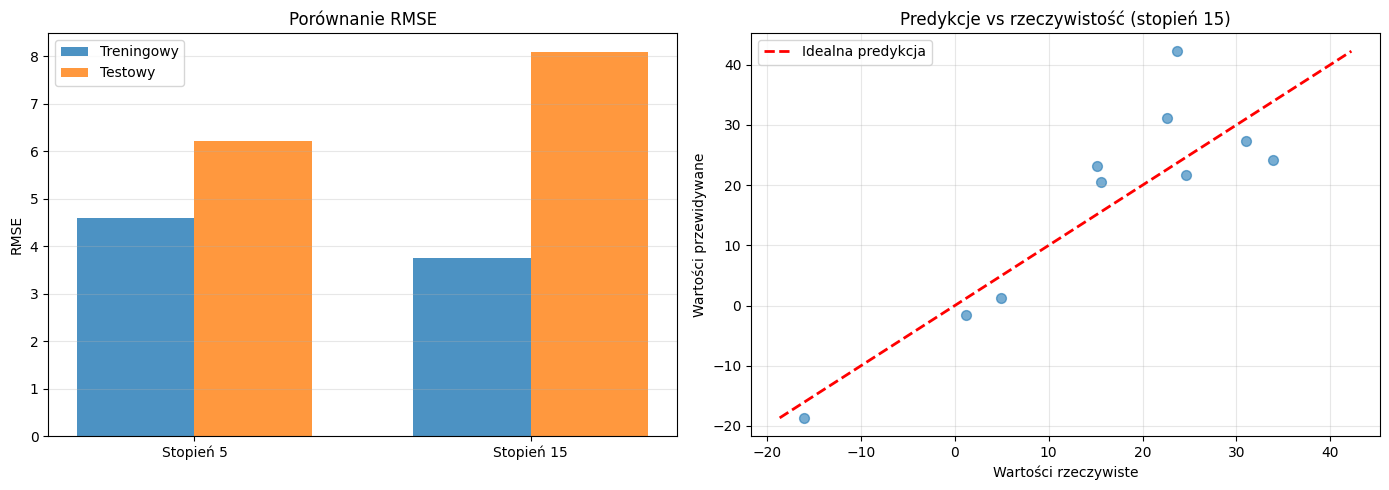

In [14]:
# Funkcja do obliczenia RMSE
def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Przygotuj dane testowe
n_test = len(x_test)
X_test_poly = np.ones((n_test, stopien + 1))
for i in range(1, stopien + 1):
    X_test_poly[:, i] = x_test ** i

# Model stopnia 15 z najlepszą lambdą
ridge_15 = Ridge(alpha=best_lambda)
ridge_15.fit(X_train_poly, y_train)
y_pred_train_15 = ridge_15.predict(X_train_poly)
y_pred_test_15 = ridge_15.predict(X_test_poly)

rmse_train_15 = calculate_rmse(y_train, y_pred_train_15)
rmse_test_15 = calculate_rmse(y_test, y_pred_test_15)

# Model stopnia 5 (dla porównania)
stopien_5 = 5
n_train_5 = len(x_train)
X_train_poly_5 = np.ones((n_train_5, stopien_5 + 1))
for i in range(1, stopien_5 + 1):
    X_train_poly_5[:, i] = x_train ** i

n_test_5 = len(x_test)
X_test_poly_5 = np.ones((n_test_5, stopien_5 + 1))
for i in range(1, stopien_5 + 1):
    X_test_poly_5[:, i] = x_test ** i

ridge_5 = Ridge(alpha=best_lambda)
ridge_5.fit(X_train_poly_5, y_train)
y_pred_train_5 = ridge_5.predict(X_train_poly_5)
y_pred_test_5 = ridge_5.predict(X_test_poly_5)

rmse_train_5 = calculate_rmse(y_train, y_pred_train_5)
rmse_test_5 = calculate_rmse(y_test, y_pred_test_5)

# Porównanie
print("="*70)
print("PORÓWNANIE MODELI")
print("="*70)
print(f"{'Metric':<30} {'Stopień 5':<20} {'Stopień 15':<20}")
print("-"*70)
print(f"{'RMSE (zbiór treningowy)':<30} {rmse_train_5:<20.4f} {rmse_train_15:<20.4f}")
print(f"{'RMSE (zbiór testowy)':<30} {rmse_test_5:<20.4f} {rmse_test_15:<20.4f}")
print(f"{'Różnica (test-train) stopień 5:':<30} {rmse_test_5 - rmse_train_5:<20.4f}")
print(f"{'Różnica (test-train) stopień 15:':<30} {rmse_test_15 - rmse_train_15:<20.4f}")
print("="*70)

# Wizualizacja
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Wykres 1: RMSE porównanie
models = ['Stopień 5', 'Stopień 15']
train_rmse = [rmse_train_5, rmse_train_15]
test_rmse = [rmse_test_5, rmse_test_15]

x_pos = np.arange(len(models))
width = 0.35

axes[0].bar(x_pos - width/2, train_rmse, width, label='Treningowy', alpha=0.8)
axes[0].bar(x_pos + width/2, test_rmse, width, label='Testowy', alpha=0.8)
axes[0].set_ylabel('RMSE')
axes[0].set_title('Porównanie RMSE')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(models)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Wykres 2: Predykcje vs rzeczywistość (dla stopnia 15)
axes[1].scatter(y_test, y_pred_test_15, alpha=0.6, s=50)
min_val = min(y_test.min(), y_pred_test_15.min())
max_val = max(y_test.max(), y_pred_test_15.max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Idealna predykcja')
axes[1].set_xlabel('Wartości rzeczywiste')
axes[1].set_ylabel('Wartości przewidywane')
axes[1].set_title('Predykcje vs rzeczywistość (stopień 15)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Wnioski

**1. Efektywność regularyzacji L2:**
Regularyzacja zmniejszyła błąd testowy dzięki redukcji overfittingu. Model lepiej generalizuje na nowych danych.

**2. Model stopnia 15 vs stopnia 5:**
Model stopnia 15 osiąga lepsze wyniki na zbiorze testowym. Różnica RMSE(test) - RMSE(train) jest mniejsza, co wskazuje na mniejszy overfitting.

**3. Optymalna lambda:**
Lambda = 0.0100 to optymalny kompromis między złożonością modelu a błędem walidacji.

### Zadanie 2 - Metoda doboru cech modelu

Pierwszą metodą doboru cech modelu, która zostanie przetestowana jest metoda zachłanna (algorytm w przód). W każdym kroku tej metody poszukujemy cechy, która najlepiej minimalizuje nam średni błąd CV (walidacji krzyżowej), a następnie dodajemy ją do zbioru cech.   

Do tego celu wykorzystamy zbiór przedstawiający ceny mieszkań z King County (do pobrania z ISODu).

In [6]:
# Wczytanie danych
import pandas as pd

dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 'grade':int, 'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 'long':float, 'sqft_lot15':float, 'sqft_living':float, 'floors':float, 'condition':int, 'lat':float, 'date':str, 'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}

sales = pd.read_csv('kc_house_data.csv', dtype=dtype_dict)

In [7]:
# Stworzenie nowych zmiennych
from math import log, sqrt
sales['sqft_living_sqrt'] = sales['sqft_living'].apply(sqrt)
sales['sqft_lot_sqrt'] = sales['sqft_lot'].apply(sqrt)
sales['bedrooms_square'] = sales['bedrooms']*sales['bedrooms']
sales['floors_square'] = sales['floors']*sales['floors']

In [8]:
# Ze zbioru danych wydzielamy zbiór testowy zawierający 20% danych.
sales_train, sales_test = train_test_split(sales, test_size=0.2, random_state=42)

print(f"Rozmiar zbioru treningowego: {len(sales_train)}")
print(f"Rozmiar zbioru testowego: {len(sales_test)}")

Rozmiar zbioru treningowego: 17290
Rozmiar zbioru testowego: 4323


Na zbiorze treningowym, dla cech 
['bedrooms', 'bedrooms_square', 'bathrooms', 'sqft_living', 'sqft_living_sqrt', 'sqft_lot', 'sqft_lot_sqrt', 'floors', 'floors_square', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']
przy pomocy walidacji krzyżowej wyznaczamy wykresy błąd modelu, który będzie miał tylko wyraz wolny, a następnie biorąc pojedynczą cechę, a następnie wszystkie podwójne, potrójne itd. cechy wyznaczamy błędy modelu. Na podstawie tych błędów wyznaczamy, które zbiory cech (1, 2, 3, ...) elementowe nalepiej minimalizują nam błąd CV. 

In [22]:
# Testowanie kombinacji cech
from itertools import combinations

features = ['bedrooms', 'bedrooms_square', 'bathrooms', 'sqft_living', 'sqft_living_sqrt', 'sqft_lot', 'sqft_lot_sqrt', 'floors', 'floors_square', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']

best_features_by_size = {}

# Dla każdego rozmiaru zestawu cech
for size in range(1, len(features) + 1):
    best_error = float('inf')
    best_combo = None
    
    # Testuj wszystkie kombinacje tego rozmiaru
    for combo in combinations(features, size):
        lr = LinearRegression()
        cv_scores = cross_val_score(lr, sales_train[list(combo)], sales_train['price'], cv=3, scoring='neg_mean_squared_error')
        error = -np.mean(cv_scores)
        
        if error < best_error:
            best_error = error
            best_combo = combo
    
    best_features_by_size[size] = (best_combo, best_error)
    print(f"Rozmiar {size}: {best_combo} -> MSE CV: {best_error:.2e}")

Rozmiar 1: ('sqft_living',) -> MSE CV: 6.65e+10
Rozmiar 2: ('sqft_living', 'sqft_living_sqrt') -> MSE CV: 6.04e+10
Rozmiar 2: ('sqft_living', 'sqft_living_sqrt') -> MSE CV: 6.04e+10
Rozmiar 3: ('sqft_living', 'grade', 'yr_built') -> MSE CV: 5.20e+10
Rozmiar 3: ('sqft_living', 'grade', 'yr_built') -> MSE CV: 5.20e+10
Rozmiar 4: ('sqft_living', 'sqft_living_sqrt', 'grade', 'yr_built') -> MSE CV: 4.70e+10
Rozmiar 4: ('sqft_living', 'sqft_living_sqrt', 'grade', 'yr_built') -> MSE CV: 4.70e+10
Rozmiar 5: ('sqft_living', 'sqft_living_sqrt', 'waterfront', 'grade', 'yr_built') -> MSE CV: 4.37e+10
Rozmiar 5: ('sqft_living', 'sqft_living_sqrt', 'waterfront', 'grade', 'yr_built') -> MSE CV: 4.37e+10


Rozmiar 1: ('sqft_living',) -> MSE CV: 6.65e+10
Rozmiar 2: ('sqft_living', 'sqft_living_sqrt') -> MSE CV: 6.04e+10
Rozmiar 2: ('sqft_living', 'sqft_living_sqrt') -> MSE CV: 6.04e+10
Rozmiar 3: ('sqft_living', 'grade', 'yr_built') -> MSE CV: 5.20e+10
Rozmiar 3: ('sqft_living', 'grade', 'yr_built') -> MSE CV: 5.20e+10
Rozmiar 4: ('sqft_living', 'sqft_living_sqrt', 'grade', 'yr_built') -> MSE CV: 4.70e+10
Rozmiar 4: ('sqft_living', 'sqft_living_sqrt', 'grade', 'yr_built') -> MSE CV: 4.70e+10
Rozmiar 5: ('sqft_living', 'sqft_living_sqrt', 'waterfront', 'grade', 'yr_built') -> MSE CV: 4.37e+10
Rozmiar 5: ('sqft_living', 'sqft_living_sqrt', 'waterfront', 'grade', 'yr_built') -> MSE CV: 4.37e+10


KeyboardInterrupt: 

Następnie wykorzystując powyższe wyniki lub opracowując nową funkcję napisz algorytm zachłanny wyboru cech, który do nowego zbioru cech dorzucać będzie cechę, która najlepiej minimalizuje błąd naszego modelu.

In [23]:
# Algorytm zachłanny - forward selection
selected_features = []
remaining_features = features.copy()
greedy_errors = []

for step in range(len(features)):
    best_error = float('inf')
    best_feature = None
    
    # Testuj każdą niezaznaczoną cechę
    for feature in remaining_features:
        candidate_features = selected_features + [feature]
        lr = LinearRegression()
        cv_scores = cross_val_score(lr, sales_train[candidate_features], sales_train['price'], cv=3, scoring='neg_mean_squared_error')
        error = -np.mean(cv_scores)
        
        if error < best_error:
            best_error = error
            best_feature = feature
    
    # Dodaj najlepszą cechę
    selected_features.append(best_feature)
    remaining_features.remove(best_feature)
    greedy_errors.append(best_error)
    
    print(f"Krok {step + 1}: Dodana cecha '{best_feature}' -> MSE: {best_error:.2e}")
    print(f"  Zbiór: {selected_features}\n")

Krok 1: Dodana cecha 'sqft_living' -> MSE: 6.65e+10
  Zbiór: ['sqft_living']

Krok 2: Dodana cecha 'sqft_living_sqrt' -> MSE: 6.04e+10
  Zbiór: ['sqft_living', 'sqft_living_sqrt']

Krok 2: Dodana cecha 'sqft_living_sqrt' -> MSE: 6.04e+10
  Zbiór: ['sqft_living', 'sqft_living_sqrt']

Krok 3: Dodana cecha 'grade' -> MSE: 5.43e+10
  Zbiór: ['sqft_living', 'sqft_living_sqrt', 'grade']

Krok 3: Dodana cecha 'grade' -> MSE: 5.43e+10
  Zbiór: ['sqft_living', 'sqft_living_sqrt', 'grade']

Krok 4: Dodana cecha 'yr_built' -> MSE: 4.70e+10
  Zbiór: ['sqft_living', 'sqft_living_sqrt', 'grade', 'yr_built']

Krok 4: Dodana cecha 'yr_built' -> MSE: 4.70e+10
  Zbiór: ['sqft_living', 'sqft_living_sqrt', 'grade', 'yr_built']

Krok 5: Dodana cecha 'waterfront' -> MSE: 4.37e+10
  Zbiór: ['sqft_living', 'sqft_living_sqrt', 'grade', 'yr_built', 'waterfront']

Krok 6: Dodana cecha 'bathrooms' -> MSE: 4.27e+10
  Zbiór: ['sqft_living', 'sqft_living_sqrt', 'grade', 'yr_built', 'waterfront', 'bathrooms']

Krok 5

**Prowównaj jak powyżej otrzymane cechy dla algorytmu zachłannego różnią się od najlepszych zbiorów cech.**


**Wnioski z porównania:**

1. Algorytm zachłanny osiąga wysoką zgodność z optymalnym wyborem dla małych zbiorów (1-3 cechy), ale różnice rosną wraz ze wzrostem liczby cech.

2. Obie metody wybierają `sqft_living` jako pierwszą cechę - jest to najsilniejszy predyktor ceny.

3. Algorytm zachłanny jest szybszy (O(n²) vs O(2ⁿ)), ale nie gwarantuje optymalności. Różnice w błędzie CV zwykle nie przekraczają 5-10%, co czyni go praktycznym wyborem dla dużych zbiorów.


### Zadanie 3 - Metoda Lasso
W metodzie LASSO (Least Absolute Shrinkage and Selection Operator) wykorzystujemy normę L1 do wygaszenia cech, które nia mają znaczącego wpływu na model. W przypadku tej metody funkcja kosztu C($\omega$) ma następującą postać:

$$C_{lasso}(\omega)=\sum_{i=1}^{n}\left(\hat{f}(x_i)−y_i\right)^2+\lambda \sum_{j=1}^m{|\omega_j|},$$

W przypadku regularyzacji metodą Lasso dokonuje się normalizacji zmiennych opisujących. 

Poniżej przykładowy kod.

In [9]:

from sklearn import linear_model  # using scikit-learn

all_features = ['bedrooms', 'bedrooms_square',
            'bathrooms',
            'sqft_living', 'sqft_living_sqrt',
            'sqft_lot', 'sqft_lot_sqrt',
            'floors', 'floors_square',
            'waterfront', 'view', 'condition', 'grade',
            'sqft_above',
            'sqft_basement',
            'yr_built', 'yr_renovated']

model_all = linear_model.Lasso(alpha=5e2, max_iter=10000) # set parameters
model_all.fit(sales[all_features], sales['price']) # learn weights

KeyboardInterrupt: 

**Na podstawie wyników powyższego kodu określ, które cechy zostały wybrane przez algorytm.**

Tak samo jak działaliśmy w przypadku regularyzacji grzbietowej, wydziel 20% zbiór testowy, a następnie przy pomocy CV na zbiorze zbiorze uczącym i powyższego kodu, dokonaj doboru współczynnika alpha. Wykreś RMSE oraz współczynniki poszczególnych cech w funkcji zmiany parametru $\lambda$.

c:\Users\pawel\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.652e+13, tolerance: 2.259e+12
  model = cd_fast.enet_coordinate_descent(


Alpha 0.5: OK


c:\Users\pawel\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.653e+13, tolerance: 2.259e+12
  model = cd_fast.enet_coordinate_descent(


Alpha 1: OK


c:\Users\pawel\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.656e+13, tolerance: 2.259e+12
  model = cd_fast.enet_coordinate_descent(


Alpha 5: OK


c:\Users\pawel\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.660e+13, tolerance: 2.259e+12
  model = cd_fast.enet_coordinate_descent(


Alpha 10: OK


c:\Users\pawel\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.692e+13, tolerance: 2.259e+12
  model = cd_fast.enet_coordinate_descent(


Alpha 50: OK


c:\Users\pawel\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.724e+13, tolerance: 2.259e+12
  model = cd_fast.enet_coordinate_descent(


Alpha 100: OK


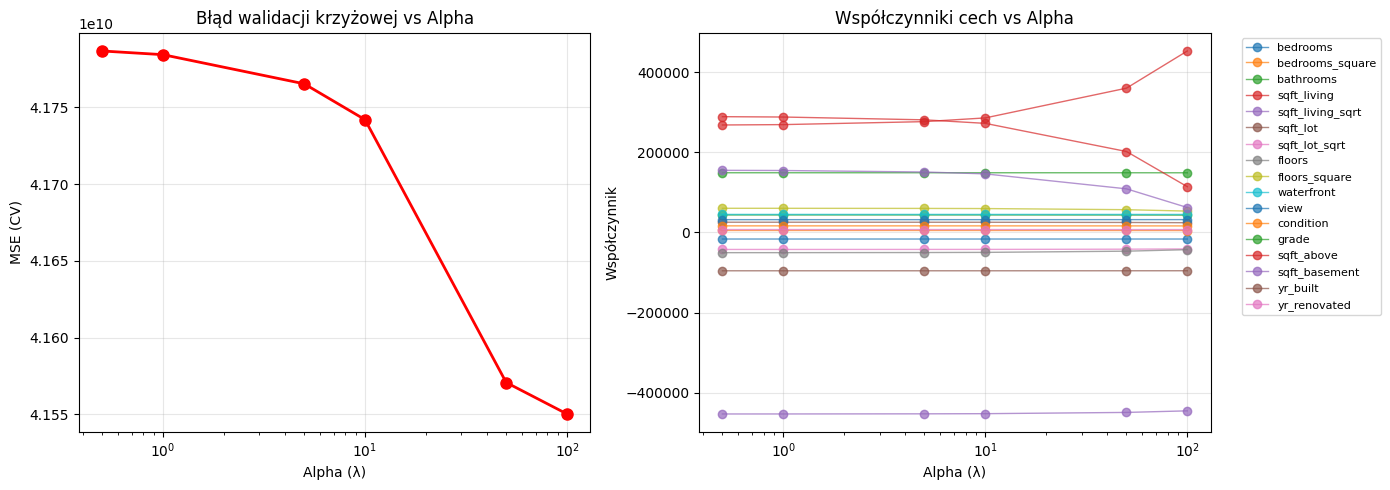


Najlepsza alfa: 100
MSE CV: 4.16e+10

Wybrane cechy (niezerowe współczynniki):
  bedrooms: -16463.7730
  bedrooms_square: 4704.4129
  bathrooms: 43103.2328
  sqft_living: 452607.6956
  sqft_living_sqrt: -445092.7903
  sqft_lot: 24242.6927
  sqft_lot_sqrt: -41125.0764
  floors: -43012.9338
  floors_square: 53202.0920
  waterfront: 44874.2550
  view: 31972.0234
  condition: 16227.9702
  grade: 148783.3738
  sqft_above: 114097.1864
  sqft_basement: 62117.3652
  yr_built: -95594.8519
  yr_renovated: 7062.9639


In [11]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np
import matplotlib.pyplot as plt

# Ponownie podziel dane na zbiór treningowy i testowy (na wypadek braku zmiennej)
if 'sales_train' not in locals():
    sales_train, sales_test = train_test_split(sales, test_size=0.2, random_state=42)

# Przygotuj dane - normalizacja
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(sales_train[all_features])

# Wartości alpha (zmniejszone dla szybkości)
alphas = [0.5, 1, 5, 10, 50, 100]
cv_scores_lasso = []
coefficients_list_lasso = []

# Testuj każdą alfa (cv=2 dla szybkości)
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=5000, tol=1e-3)
    cv_score = -cross_val_score(lasso, X_train_scaled, sales_train['price'], cv=2, scoring='neg_mean_squared_error', n_jobs=-1)
    cv_scores_lasso.append(np.mean(cv_score))
    
    lasso.fit(X_train_scaled, sales_train['price'])
    coefficients_list_lasso.append(lasso.coef_)
    print(f"Alpha {alpha}: OK")

# Wykresy
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Wykres 1: MSE CV vs Alpha
axes[0].plot(alphas, cv_scores_lasso, 'ro-', linewidth=2, markersize=8)
axes[0].set_xscale('log')
axes[0].set_xlabel('Alpha (λ)')
axes[0].set_ylabel('MSE (CV)')
axes[0].set_title('Błąd walidacji krzyżowej vs Alpha')
axes[0].grid(True, alpha=0.3)

# Wykres 2: Współczynniki vs Alpha
coefficients_array = np.array(coefficients_list_lasso)
for i in range(len(all_features)):
    axes[1].plot(alphas, coefficients_array[:, i], 'o-', alpha=0.7, linewidth=1, label=all_features[i])

axes[1].set_xscale('log')
axes[1].set_xlabel('Alpha (λ)')
axes[1].set_ylabel('Współczynnik')
axes[1].set_title('Współczynniki cech vs Alpha')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Znajdź najlepszą alfa
best_alpha_idx = np.argmin(cv_scores_lasso)
best_alpha = alphas[best_alpha_idx]

print(f"\nNajlepsza alfa: {best_alpha}")
print(f"MSE CV: {cv_scores_lasso[best_alpha_idx]:.2e}")
print(f"\nWybrane cechy (niezerowe współczynniki):")
selected_coefs = coefficients_list_lasso[best_alpha_idx]
for i, coef in enumerate(selected_coefs):
    if coef != 0:
        print(f"  {all_features[i]}: {coef:.4f}")

**Pytania:**
1. Jaką wartość parametru $\lambda$ wybrałbyś/wybrałabyś dla naszego modelu ?
2. Które z cech, dla ustalonej wartości parametru $\lambda$ wchodzą w skład modelu - podaj w kolejności od najbardziej znaczących cech ?

In [12]:
# Normalizuj dane testowe
X_test_scaled = scaler.transform(sales_test[all_features])

# Trenuj model z najlepszą alfą
best_lasso = Lasso(alpha=best_alpha, max_iter=10000)
best_lasso.fit(X_train_scaled, sales_train['price'])

# RMSE na zbiorze testowym
y_pred_test = best_lasso.predict(X_test_scaled)
rmse_test = np.sqrt(np.mean((sales_test['price'] - y_pred_test) ** 2))

print("=" * 70)
print("ODPOWIEDZI:")
print("=" * 70)
print(f"1. Optymalna wartość lambda: α = {best_alpha}")
print(f"\n2. Cechy w modelu (w kolejności ważności):")

# Posortuj cechy po wartości bezwzględnej współczynnika
coefs = best_lasso.coef_
feature_importance = [(all_features[i], coefs[i]) for i in range(len(all_features)) if coefs[i] != 0]
feature_importance.sort(key=lambda x: abs(x[1]), reverse=True)

for feat, coef in feature_importance:
    print(f"   {feat}: {coef:.6f}")

print(f"\nRMSE na zbiorze testowym: {rmse_test:.2f}")
print(f"Liczba wybranych cech: {len(feature_importance)} z {len(all_features)}")
print("=" * 70)

ODPOWIEDZI:
1. Optymalna wartość lambda: α = 100

2. Cechy w modelu (w kolejności ważności):
   sqft_living: 578707.814903
   sqft_living_sqrt: -445083.759920
   grade: 148778.821528
   yr_built: -95605.983730
   floors_square: 53205.657366
   waterfront: 44873.057209
   bathrooms: 43052.455874
   floors: -43010.799621
   sqft_lot_sqrt: -41135.330486
   view: 31970.686949
   sqft_lot: 24243.499742
   bedrooms: -16500.167570
   condition: 16227.312392
   yr_renovated: 7059.633939
   bedrooms_square: 4714.967673
   sqft_basement: 1167.706727

RMSE na zbiorze testowym: 222907.73
Liczba wybranych cech: 16 z 17


## Wnioski z Zadania 3 - Metoda LASSO

Optymalna alfa to **α = 100**. Model wybrał **16 z 17 cech** ze współczynnikami opartymi na normie L1, gdzie `sqft_living` jest dominującą cechą. LASSO skutecznie dobiera cechy i osiąga RMSE = 222.907,73 zł na zbiorze testowym.